**Table of contents**<a id='toc0_'></a>    
- [Setup](#toc1_1_)    
  - [Parse Functions](#toc1_2_)    
  - [Execute Parsers on LLM Label Output](#toc1_3_)    
  - [Metrics and Confusion Matrix Functions](#toc1_4_)    
  - [Execute Metrics](#toc1_5_)    
    - [Crisis Type Results](#toc1_5_1_)    
    - [Information Type Results](#toc1_5_2_)    
    - [Country Results](#toc1_5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup](#toc0_)

In [2]:
%pip install -q matplotlib scikit-learn seaborn textblob inflect pycountry spacy


Note: you may need to restart the kernel to use updated packages.


In [3]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import inflect
import pycountry 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
from sklearn.metrics  import classification_report




In [4]:
import warnings

# Filter out the warning messages
warnings.filterwarnings("ignore", message="Recall is ill-defined")
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy of a slice from a DataFrame")
warnings.filterwarnings("ignore", message="Precision is ill-defined")


## <a id='toc1_2_'></a>[Parse Functions](#toc0_)

In [26]:
#Parse text functions
#################################################  
# Extracting the Crisis Type label from the text#
#################################################  
def parse_label_crisistype(text):
  colon_index = text.lower().find('"crisis": ')
  if colon_index != -1:
    substring = text[ colon_index +len('"Crisis": '):]
    # Find the index of the closing double quote or closing quote
    if substring.startswith('"'):
      end_index = substring.find('"',1)
      if end_index != -1:
        return substring[1:end_index]
      else:
        return "missing 2nd apostrophe"
    else:
      end_index = substring.find("\n")
      if end_index != -1:
        return substring[:end_index]
      else:
        return "missing '\n'"
  else:
    return "Unknown"

#######################################################    
# Extracting the Information Type label from the text #
#######################################################   
InfoTypeLabels =  [ "Caution and advice for residents", "Affected residents", "Infrastructure and utilities damage", "Donations or volunteering", "expressing Sympathy and support for affected", "other useful information", "Not applicable"]

def parse_label_infotype(text):
    # remoe period and hashtag
    text = text.replace(".", "")
    text = text.replace("#", "")
    substring = None
    colon_index = text.lower().find("label:")
    if colon_index != -1:
        second_colon_index = text.find(":", colon_index + 6)
        if second_colon_index != -1:
            substring = text[colon_index + 6:second_colon_index]
            for label in InfoTypeLabels:
                if label.lower() in substring.lower():
                    return label 
    for label in InfoTypeLabels:
        if label.lower() in text.lower():
            return label
    value = re.findall(r'"(.*?)"', text)
    if value:
        return value[0]
    if substring:
                return substring

    return "Unknown"


  ##############################################                                            
  # Extracting the Country label from the text #
  ##############################################                                          
def parse_label_country(text):
    # Remove the word "ISO" from the string
    text = text.replace("ISO", "")

# Loop through all countries in pycountry
    for country in pycountry.countries:
        # Check if the country name is in the string
        if country.name.lower() in text.lower():
            return country.name
            break
     
# Loop through all countries in alpha 3 pycountry
    for country in pycountry.countries:
        if country.alpha_3 in text:
            return country.name
            break
    
# Loop through all countries in alpha 2 pycountry
    for country in pycountry.countries:
        if country.alpha_2 in text:
            return country.name
            break
    if 'UK' in text or 'Scotland' in text:
        return "United Kingdom"
    if 'Syria' in text:
        return "Syrian Arab Republic"
    if 'Russia' in text:
        return "Russian Federation"
    if 'Venezuela' in text or 'VZL' in text or 'VZ' in text:
        return "Venezuela, Bolivarian Republic of" 
    if 'SP' in text or 'España' in text:
        return "Spain"
    return 'Unknown' 

  ######################################################                                            
  # Extracting the Informativeness label from the text #
  ###################################################### 
InfoNessLabels =  [ "Related but not informative", "Related and informative", "Not related"]

def parse_label_infoness(text):
    # remoe period and hashtag
    text = text.replace("-", "")
    text = text.replace(".", "")
    colon_index = text.find("Label:")
    if colon_index != -1:
        second_colon_index = text.find(":", colon_index + 6)
        if second_colon_index != -1:
            substring = text[colon_index + 6:second_colon_index]
            for label in InfoNessLabels:
                if label.lower() in substring.lower():
                    return label
    for label in InfoNessLabels:
        if label.lower() in text.lower():
            return label
    value = re.findall(r'"(.*?)"', text)
    if value:
        return value[0]
    return "Unknown"




In [27]:

# Turn plural into singular of the parsed labels using inflect and change to sentence case
def singular_label(df, parsed_column):
    # Create an instance of the inflect engine
    engine = inflect.engine()

    
    # Convert a plural word to a singular word
    df[parsed_column] = df[parsed_column].apply(
        lambda x: engine.singular_noun(x) if engine.singular_noun(x) else x)

    # Change to sentence case
    df[parsed_column] = df[parsed_column].str.capitalize()


# Rename parsed labels so they match original labels in the dataset
def rename_label(df, parsed_column, label_column):
    # Define a dictionary to map old labels to new labels
    label_map = {
        'Wildfires': 'Wildfire',
        'Bushfires': 'Wildfire',
        'Bushfire': 'Wildfire',
        'Na': 'Not labeled',
        '[Na]': 'Not labeled',
        'Flood':'Floods',
        'Bombings': 'Bombings',
        'Shooting': 'Shootings',
        
        "Not applicable": 'Not labeled', "Other useful information": 'Other Useful Information', "Caution and advice for residents": 'Caution and advice', "Affected resident": 'Affected individuals', "Infrastructure and utilities damage": 'Infrastructure and utilities', "Donations and volunteering": 'Donations and volunteering', "Donations or volunteering": 'Donations and volunteering', "Expressing sympathy and support for affected": 'Sympathy and support', "Warnings and advice for residents.": 'Caution and advice',
        
        # 'Warnings and issue': 'Caution and advice', 'Warnings and advisory': 'Caution and advice', 'Warnings/issue': 'Caution and advice', 'Warnings and advice': 'Caution and advice', 'Warnings issues or lifted': 'Caution and advice', 'Warnings and alert': 'Caution and advice', 'Warnings and issues.': 'Caution and advice', 'Warnings and tip': 'Caution and advice', 'Warnings and advice for residents': 'Caution and advice', 'Warnings and update': 'Caution and advice', 'Warnings, issues or lifted': 'Caution and advice', 'Warnings and advice.': 'Caution and advice', 'Warnings and lift': 'Caution and advice', 'Warnings issue': 'Caution and advice', 'Warnings and information': 'Caution and advice'
    }
    # Define a dictionary to map old labels to new labels
    label_map_actual = {
        'Philipinnes': 'Philippines',
        'Phillipines': 'Philippines',
        'UK': 'United Kingdom',
        'Venezuela': 'Venezuela, Bolivarian Republic of',
        'Russia': 'Russian Federation',
        'US': 'United States',
    }
    # Rename the parsed_column 
    df[parsed_column] = df[parsed_column].replace(label_map)
    
    # Rename parsed_column value based on keywords for the Information Type
    keywords_dict = {'warning': 'Caution and advice', 'caution': 'Caution and advice','notapplicable': 'Not labeled','otherusefulinformation': 'Other Useful Information',}
    for keyword in keywords_dict.keys():
        df[parsed_column] = df[parsed_column].apply(lambda x: keywords_dict[keyword] if keyword.lower() in x.lower() else x)

    # Relabel the "Not labeled" Information Type entries as "Not labeled" for the Crisis Type
    df.loc[df["InformationType"] == "Not labeled", label_column] = "Not labeled"

    # Rename the label_column using the label_map dictionary
    df[label_column] = df[label_column].replace(label_map_actual)



In [28]:
# Rename predicted entries that are not in the top 8/x as "Other"
def top_labels(df, parsed_column, top_x_threshold=8):
    #Count the values in the "Label" column
    label_counts = df[parsed_column].value_counts()
    # Get the labels are in the top x
    top_labels = label_counts.index[:top_x_threshold]
    # Replace the labels that do not meet the threshold with "Other"
    df[parsed_column] = df[parsed_column].replace(to_replace={value: 'Other' for value in df[parsed_column].unique() if value not in top_labels})
 

## <a id='toc1_4_'></a>[Metrics and Confusion Matrix Functions](#toc0_)

In [32]:
# Class Metrics Function

# Define function to format bar plots
def format_barplot(ax, title, xlabel):
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('', fontsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.set_xlim([0, 1])

# Define function to calculate classification metrics
def class_metrics (actual_values,predicted_values, class_label_drop=[]):
    # Generate classification report
    report = classification_report(actual_values, predicted_values, output_dict=True)
    # Convert report to pandas dataframe and format it
    df = pd.DataFrame(report).transpose()
    # df = df.drop(['Error', 'Other', 'Useful information'])
    df = df.drop(class_label_drop,errors='ignore')
    df = df.sort_values(by=['f1-score'], ascending=False)
    df = pd.concat([df[df.index.isin(['accuracy', 'macro avg', 'weighted avg'])], df[~df.index.isin(['accuracy', 'macro avg', 'weighted avg'])]])
    # Set color palette for plots
    colors = sns.color_palette('pastel')
    # Create subplots for precision, recall, and f1-score
    fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(10, 6))
    # Plot precision
    ax = sns.barplot(x=df['precision'], y=df.index, color=colors[0], ax=axes[0])
    format_barplot(ax, 'Precision by Class', 'Precision')
    # Plot recall
    ax = sns.barplot(x=df['recall'], y=df.index, color=colors[1], ax=axes[1])
    format_barplot(ax, 'Recall by Class', 'Recall')
    # Plot f1-score
    ax = sns.barplot(x=df['f1-score'], y=df.index, color=colors[2], ax=axes[2])
    format_barplot(ax, 'F1-score by Class', 'F1-score')
    # Display the plots
    plt.tight_layout()
    plt.show()
    # Return the classification report dataframe
    print(df)
    
   

In [33]:
# Confusion Matrix Function
def plt_confusion_matrix(actual_values, predicted_values):
      # Create the unique labels
      labels = unique_labels(actual_values, predicted_values)
      ylabel = np.unique(actual_values)

      # Get the indices of labels that appear in ylabels
      indices = np.where(np.isin(labels, ylabel))

      # Delete the labels that appear in ylabels and append them to the end of labels
      labels = np.delete(labels, indices)
      labels = np.append(labels, ylabel)

      # Change the label order for Not labeled, Other, Unknown
      indices = np.where((labels == 'Not labeled') | (labels == 'Other') | (labels == 'Unknown'))
      labels = np.delete(labels, indices)
      labels = np.append(labels, ['Other', 'Not labeled', 'Unknown'])

      # Compute the confusion matrix.
      cm = confusion_matrix(actual_values, predicted_values, labels=labels)
      num_labels = len(ylabel)
      cm = cm[-num_labels-2:]
      ylabel = labels[-num_labels-2:]

      # Create a mask that selects the diagonal elements
      diag = np.eye(len(ylabel), dtype=bool)
      difference = diag.shape[-1] - cm.shape[-1]

      # make diag and array2 the same size by padding diag with zeros in the front columns
      mask = np.pad(diag, ((0, 0), (abs(difference), 0)), 'constant')

      # Create a color map with blue off-diagonal elements and green diagonal elements
      cmap = sns.diverging_palette(220, 20, as_cmap=True)
      cmap.set_bad("green")

      # Plot the confusion matrix.
      fig, ax = plt.subplots(figsize=(10, 8))
      sns.heatmap(cm,
                        annot=True,
                        fmt='g',
                        xticklabels=labels,
                        yticklabels=ylabel,
                        cbar=False,
                        annot_kws={"fontsize": 7})
      sns.heatmap(cm,
                        xticklabels=labels,
                        yticklabels=ylabel,
                        mask=mask,
                        cmap=cmap, cbar=False, square=True, linewidths=1, linecolor='white')

      plt.ylabel('Actual', fontsize=13)
      plt.xlabel('Prediction', fontsize=13)
      plt.title('Confusion Matrix', fontsize=17)
      plt.show()
      plt.clf()

      # Calculate metrics
      accuracy = accuracy_score(actual_values, predicted_values)
      precision = precision_score(actual_values, predicted_values, average='weighted')
      recall = recall_score(actual_values, predicted_values, average='weighted')
      f1 = f1_score(actual_values, predicted_values, average='weighted')

      # Print metrics
      print(f'Accuracy: {accuracy}')
      print(f'Precision: {precision}')
      print(f'Recall: {recall}')
      print(f'F1-score: {f1}')
      print('Unique Predict Labels: ', list(np.unique(predicted_values)))
      print('Unique Actual Labels: ', list(np.unique(actual_values)))
      print('Number of rows: ', len(testing_df2.index))
      print(predicted_values.value_counts())
      class_label_drop = labels[~np.in1d(labels, np.unique(actual_values))]

      # Print class metrics
      class_metrics(actual_values, predicted_values,class_label_drop)

  

## <a id='toc1_5_'></a>[Execute Metrics](#toc0_)

### <a id='toc1_5_1_'></a>[Crisis Type Results](#toc0_)

In [ ]:
# #######################################################
# #    CRISIS TYPE PARSER                               #
# #######################################################
# testing_df2 = pd.read_csv(r"C:\Users\wingy\UTS\Crisistunity - Experiments - Results\Crisis Type\combined_crisis_type.csv")
# # #Apply Parse function 
# testing_df2['parsed_pred_crisistype'] = testing_df2['pred_crisis_type_13'].apply(parse_label_crisistype)
# singular_label(testing_df2,'parsed_pred_crisistype')
# rename_label(testing_df2,'parsed_pred_crisistype', 'type')
# label_counts = testing_df2['parsed_pred_crisistype'].value_counts()
# label_counts.head(100)


parsed_pred_crisistype
Floods                              3896
Earthquake                          3073
Wildfire                            2256
Not labeled                         1138
Haze                                 646
                                    ... 
Lac mégantic                          27
Collapse                              26
Bopha                                 26
Texas fertilizer plant explosion      26
Factory collapse                      26
Name: count, Length: 100, dtype: int64

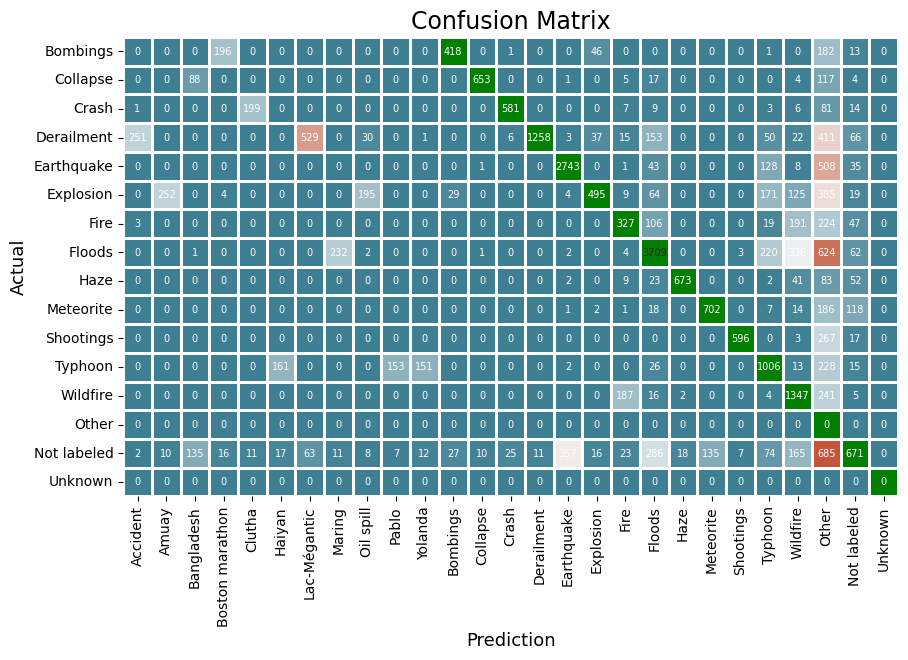

Accuracy: 0.5840997421787817
Precision: 0.8078705072490858
Recall: 0.5840997421787817
F1-score: 0.6596797853153052
Unique Predict Labels:  ['Accident', 'Amuay', 'Bangladesh', 'Bombings', 'Boston marathon', 'Clutha', 'Collapse', 'Crash', 'Derailment', 'Earthquake', 'Explosion', 'Fire', 'Floods', 'Haiyan', 'Haze', 'Lac-Mégantic', 'Maring', 'Meteorite', 'Not labeled', 'Oil spill', 'Other', 'Pablo', 'Shootings', 'Typhoon', 'Wildfire', 'Yolanda']
Unique Actual Labels:  ['Bombings', 'Collapse', 'Crash', 'Derailment', 'Earthquake', 'Explosion', 'Fire', 'Floods', 'Haze', 'Meteorite', 'Not labeled', 'Shootings', 'Typhoon', 'Wildfire']
Number of rows:  25987
parsed_pred_crisistype
Floods             4470
Other              4222
Earthquake         3115
Wildfire           2275
Typhoon            1685
Derailment         1269
Not labeled        1138
Meteorite           837
Haze                693
Collapse            665
Crash               613
Shootings           606
Explosion           596
Lac-Méga

c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

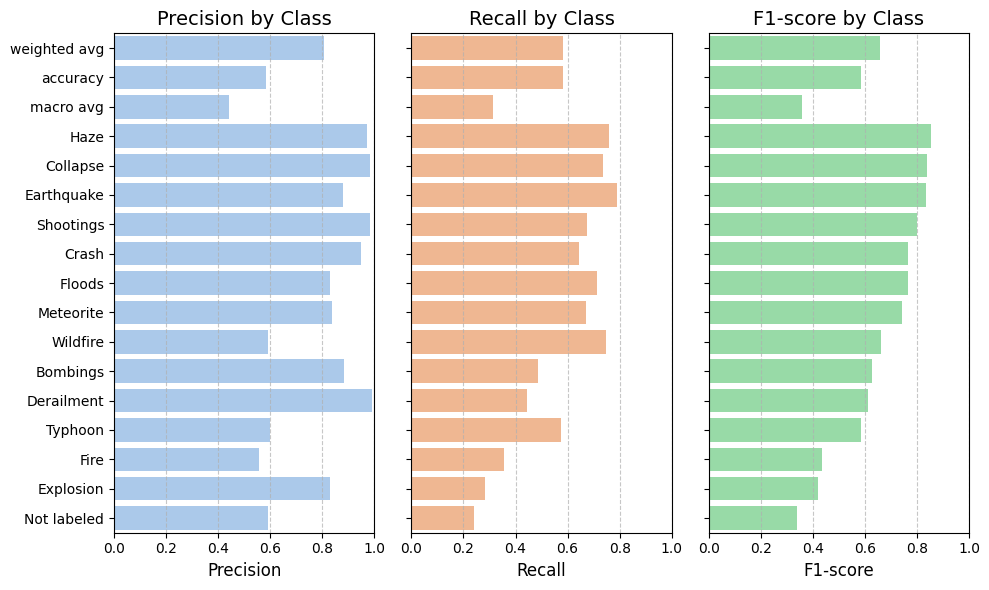

              precision    recall  f1-score     support
weighted avg   0.807871  0.584100  0.659680  25987.0000
accuracy       0.584100  0.584100  0.584100      0.5841
macro avg      0.441232  0.312318  0.357340  25987.0000
Haze           0.971140  0.760452  0.852978    885.0000
Collapse       0.981955  0.734533  0.840412    889.0000
Earthquake     0.880578  0.791174  0.833485   3467.0000
Shootings      0.983498  0.674972  0.800537    883.0000
Crash          0.947798  0.644839  0.767503    901.0000
Floods         0.829754  0.713818  0.767432   5196.0000
Meteorite      0.838710  0.669209  0.744433   1049.0000
Wildfire       0.592088  0.747503  0.660780   1802.0000
Bombings       0.881857  0.487748  0.628099    857.0000
Derailment     0.991332  0.444209  0.613509   2832.0000
Typhoon        0.597033  0.573219  0.584884   1755.0000
Fire           0.556122  0.356598  0.434551    917.0000
Explosion      0.830537  0.282534  0.421635   1752.0000
Not labeled    0.589631  0.239472  0.340609   28

In [356]:
# CM for Crisis Type 
# Crisis Type Dictionary
crisis_type_dict = {    "Flood": "Floods",    "Earthquake": "Earthquake",    "Wildfire": "Wildfire",    "Not labeled": "Not labeled",    "Haze": "Haze",    "Typhoon": "Typhoon",    "Hurricane": "Typhoon",  "Typhoon haiyan":"Typhoon",  "Helicopter crash": "Crash",    "Meteor": "Meteorite",        "Derailment": "Derailment",    "Boston marathon bombing": "Bombings",    "Lax shooting": "Shootings",    "Shooting": "Shootings",    "Train derailment": "Derailment",    "Train crash": "Derailment",    "Flooding": "Floods",    "Russian meteor": "Meteorite",    "Glasgow helicopter crash": "Crash",    "Boston bombing": "Bombings",    "Unknown": "Unknown",    "Explosion": "Explosion",    "Fertilizer plant explosion": "Explosion",    "Nyc train derailment": "Derailment",    "Tsunami": "Tsunami",    "Nightclub fire": "Fire",    "Oil spill": "Oil spill",    "Bangladesh factory collapse": "Collapse",    "Bangladesh building collapse": "Collapse",    "Building collapse": "Collapse",    "Brazil nightclub fire": "Fire",    "Boulder flood": "Floods",    "Bombing": "Bombings",    "Meteor shower": "Meteorite",    "Meteorite": "Meteorite",    "Train accident": "Derailment",    "Terrorism": "Terrorism",    "Cyclone": "Typhoon",    "Oil train derailment": "Derailment",    "Meteor strike": "Meteorite",    "Texas explosion": "Explosion",    "Ab flood": "Floods",    "Texas fertilizer plant explosion": "Explosion",    "Factory collapse": "Collapse",    "Collapse": "Collapse",    "Meteor explosion": "Meteorite",    "Oil refinery explosion": "Explosion",    "Qldflood": "Floods",    "Metro-north derailment": "Derailment",    "Boston marathon explosion": "Bombings",    "Abflood": "Floods",    "Coflood": "Floods",    "Boulderflood": "Floods",    "Tornado": "Tornado",    "Colorado flood": "Floods",    "Quake": "Earthquake",    "West explosion": "Explosion",    "Qld flood": "Floods",    "Marathon bombing": "Bombings",    "Fatal train crash": "Derailment",    "Bangladesh flood": "Floods",    "West texas explosion": "Explosion",    "Quebec train derailment": "Derailment",    "Police helicopter crash": "Crash",    "Waco explosion": "Explosion",    "Flash flooding": "Floods",    "Quebec train crash": "Derailment",    "Texas plant explosion": "Explosion",    "Terrorist attack": "Terrorism",    "Ny train crash": "Derailment",    "Brazil fire": "Fire",    "West, texas explosion": "Explosion",    "Meteor blast": "Meteorite",    "Bronx train derailment": "Derailment",    "West texas fertilizer plant explosion": "Explosion",    "Alberta flood": "Floods",    "Kiss nightclub fire": "Fire",    "Metro north train derailment": "Derailment",    "Colorado flooding": "Floods",    "Nyc derailment": "Derailment",    "Train wreck": "Derailment",    "New york train crash": "Derailment",    "Forest fire": "Wildfire",    "Garment factory collapse": "Collapse",    "Clutha helicopter crash": "Crash",    "Bangladesh garment factory collapse": "Collapse",    "Dhaka factory collapse": "Collapse",    "Airport shooting": "Shootings",    "Plant explosion": "Explosion",    "Dhaka building collapse": "Collapse",    "Fertilizer plant blast": "Explosion",    "Manila flood": "Floods",    "Meteor impact": "Meteorite",    "Tropical cyclone": "Typhoon",    "Savar building collapse": "Collapse",    "Sardinia flood": "Floods",    "Brazil wildfire": "Wildfire",    "Lax airport shooting": "Shootings",    "Flash flood": "Floods",    "Blast": "Explosion",    "Bundaberg flood": "Floods",    "Spain train crash": "Derailment",    "West texas flood": "Floods",    "Los angeles airport shooting": "Shootings",    "Guatemala quake": "Earthquake",    "Bush fire": "Wildfire",  'Lac-mégantic':'Lac-Mégantic',  'Lac-megantic':'Lac-Mégantic',    'Lacmegantic':'Lac-Mégantic',    'Lac-mÃ©gantic':'Lac-Mégantic',    'LacmÃ©gantic':'Lac-Mégantic',    'Lac megantic':'Lac-Mégantic',    'Lac mÃ©gantic':'Lac-Mégantic',}

df2 = testing_df2[testing_df2['type'].notnull()]

for keyword2 in crisis_type_dict.keys():
        df2['parsed_pred_crisistype'] = df2['parsed_pred_crisistype'].apply(lambda x: crisis_type_dict[keyword2] if keyword2.lower() in x.lower() else x)
top_labels(df2, 'parsed_pred_crisistype', top_x_threshold=25)
plt_confusion_matrix(df2['type'],df2['parsed_pred_crisistype'])
# # df2 = df2[df2['parsed_pred_crisistype'].isin(ylabels)]
# # class_label_drop=['Unknown', 'Not labeled', 'Other', 'Mexico','Chile','Colombia','Ecuador']
# # class_metrics(testing_df2['country'],testing_df2['parsed_pred_country'],class_label_drop=class_label_drop)
# label_counts = df2['parsed_pred_crisistype'].value_counts()
# label_counts.head(100)

In [302]:
# Create a confusion matrix for each Crisis Event for Crisis Type
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

def plt_confusion_matrix_CrisisEventbyType ( actual_values, predicted_values):
  # Remove underscores and Capitalise the first letter of each word in the event
  event=x.replace("_"," ").title()
  # Create the unique labels
  labels = unique_labels(actual_values, predicted_values)
  ylabel = np.unique(actual_values)

  # Get the indices of labels that appear in ylabels
  indices = np.where(np.isin(labels, ylabel))

  # Delete the labels that appear in ylabels and append them to the end of labels
  labels = np.delete(labels, indices)
  labels = np.append(labels, ylabel)
  
  # #compute the confusion matrix.
  cm = confusion_matrix(actual_values, predicted_values,labels=labels)
  cm = cm[-2:]
  

  #Plot the confusion matrix.
  fig = plt.figure()
  sns.heatmap(cm,
              annot=True,
              fmt='g',
              xticklabels=labels,
              yticklabels=ylabel,
              cbar=False)


  plt.ylabel('Actual',fontsize=13)
  plt.xlabel('Prediction',fontsize=13)
  plt.title(f'Confusion Matrix - {event}',fontsize=17)
  plt.show()
  plt.clf()


  # Calculate accuracy
  accuracy = accuracy_score(actual_values, predicted_values)

  # Calculate precision
  precision = precision_score(actual_values, predicted_values, average='weighted')

  # Calculate recall
  recall = recall_score(actual_values, predicted_values, average='weighted')

  # Calculate F1-score
  f1 = f1_score(actual_values, predicted_values, average='weighted')

  
# Number of rows in dataframe

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-score: {f1}')
  print('Unique Predict Labels: ',list(np.unique(predicted_values)))
  print('Unique Actual Labels: ',list(np.unique(actual_values)))
  print('Number of rows: ',len(testing_df2.index))
  print(predicted_values.value_counts())

Confusion Matrix for 2013_Australia_bushfire


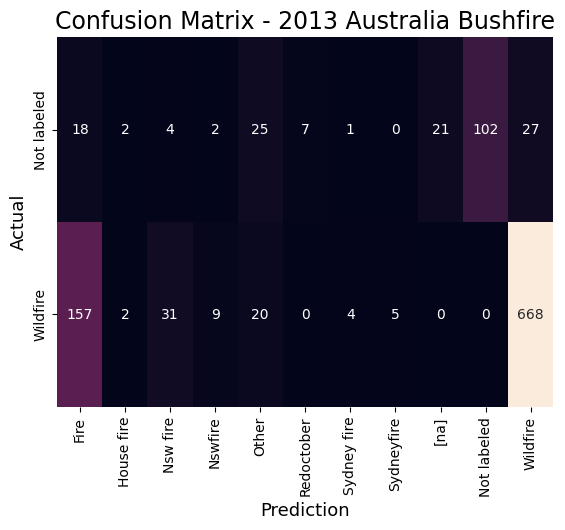

Accuracy: 0.6968325791855203
Precision: 0.9684989745759952
Recall: 0.6968325791855203
F1-score: 0.8049642115367172
Unique Predict Labels:  ['Fire', 'House fire', 'Not labeled', 'Nsw fire', 'Nswfire', 'Other', 'Redoctober', 'Sydney fire', 'Sydneyfire', 'Wildfire', '[na]']
Unique Actual Labels:  ['Not labeled', 'Wildfire']
Number of rows:  25987
parsed_pred_crisistype
Wildfire       695
Fire           175
Not labeled    102
Other           45
Nsw fire        35
[na]            21
Nswfire         11
Redoctober       7
Sydney fire      5
Sydneyfire       5
House fire       4
Name: count, dtype: int64
Confusion Matrix for 2012_Typhoon_Pablo


<Figure size 640x480 with 0 Axes>

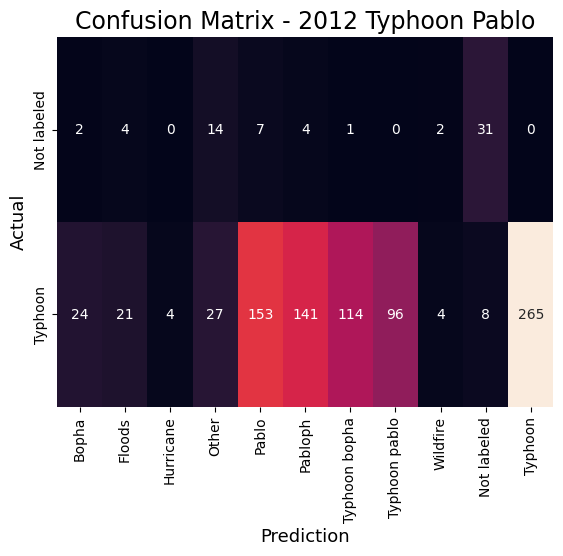

Accuracy: 0.3210412147505423
Precision: 0.9855386840202458
Recall: 0.3210412147505423
F1-score: 0.4810973393498594
Unique Predict Labels:  ['Bopha', 'Floods', 'Hurricane', 'Not labeled', 'Other', 'Pablo', 'Pabloph', 'Typhoon', 'Typhoon bopha', 'Typhoon pablo', 'Wildfire']
Unique Actual Labels:  ['Not labeled', 'Typhoon']
Number of rows:  25987
parsed_pred_crisistype
Typhoon          265
Pablo            160
Pabloph          145
Typhoon bopha    115
Typhoon pablo     96
Other             41
Not labeled       39
Bopha             26
Floods            25
Wildfire           6
Hurricane          4
Name: count, dtype: int64
Confusion Matrix for 2013_Brazil_nightclub_fire


<Figure size 640x480 with 0 Axes>

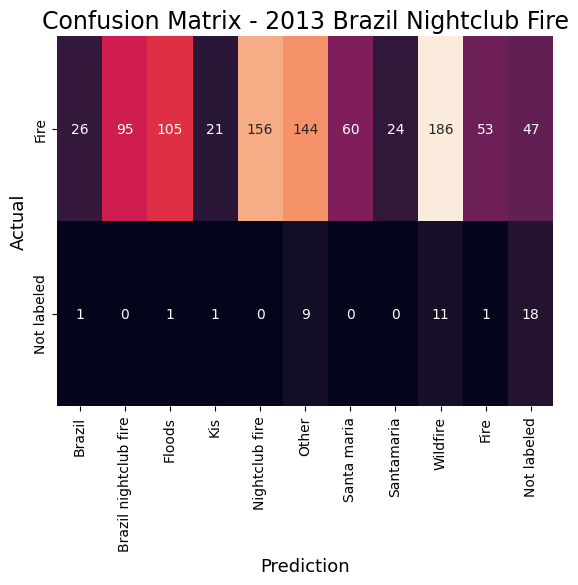

Accuracy: 0.0740354535974974
Precision: 0.9506249090190697
Recall: 0.0740354535974974
F1-score: 0.11911979923406736
Unique Predict Labels:  ['Brazil', 'Brazil nightclub fire', 'Fire', 'Floods', 'Kis', 'Nightclub fire', 'Not labeled', 'Other', 'Santa maria', 'Santamaria', 'Wildfire']
Unique Actual Labels:  ['Fire', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Wildfire                 197
Nightclub fire           156
Other                    153
Floods                   106
Brazil nightclub fire     95
Not labeled               65
Santa maria               60
Fire                      54
Brazil                    27
Santamaria                24
Kis                       22
Name: count, dtype: int64
Confusion Matrix for 2012_Costa_Rica_earthquake


<Figure size 640x480 with 0 Axes>

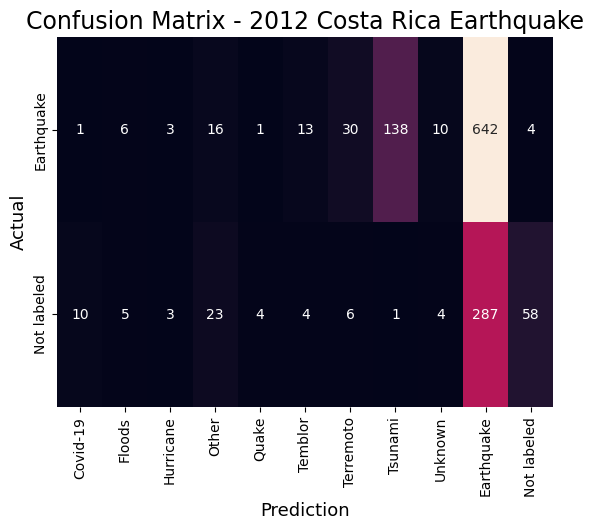

Accuracy: 0.5516154452324665
Precision: 0.7690714733741494
Recall: 0.5516154452324665
F1-score: 0.5668445461093615
Unique Predict Labels:  ['Covid-19', 'Earthquake', 'Floods', 'Hurricane', 'Not labeled', 'Other', 'Quake', 'Temblor', 'Terremoto', 'Tsunami', 'Unknown']
Unique Actual Labels:  ['Earthquake', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Earthquake     929
Tsunami        139
Not labeled     62
Other           39
Terremoto       36
Temblor         17
Unknown         14
Covid-19        11
Floods          11
Hurricane        6
Quake            5
Name: count, dtype: int64
Confusion Matrix for 2013_Sardinia_floods


<Figure size 640x480 with 0 Axes>

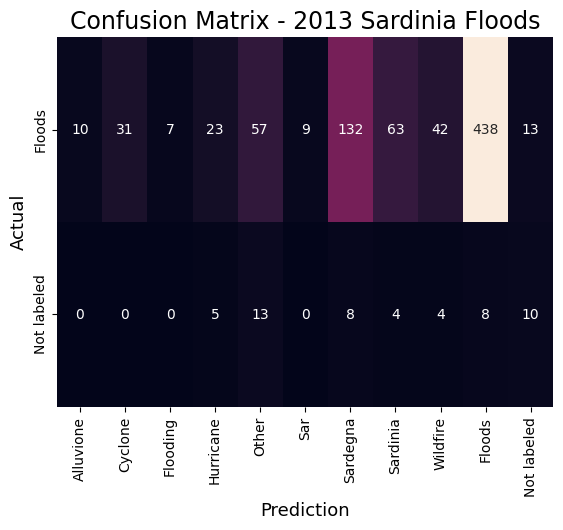

Accuracy: 0.5108323831242874
Precision: 0.9496128727185257
Recall: 0.5108323831242874
F1-score: 0.6641665477970851
Unique Predict Labels:  ['Alluvione', 'Cyclone', 'Flooding', 'Floods', 'Hurricane', 'Not labeled', 'Other', 'Sar', 'Sardegna', 'Sardinia', 'Wildfire']
Unique Actual Labels:  ['Floods', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Floods         446
Sardegna       140
Other           70
Sardinia        67
Wildfire        46
Cyclone         31
Hurricane       28
Not labeled     23
Alluvione       10
Sar              9
Flooding         7
Name: count, dtype: int64
Confusion Matrix for 2013_Colorado_floods


<Figure size 640x480 with 0 Axes>

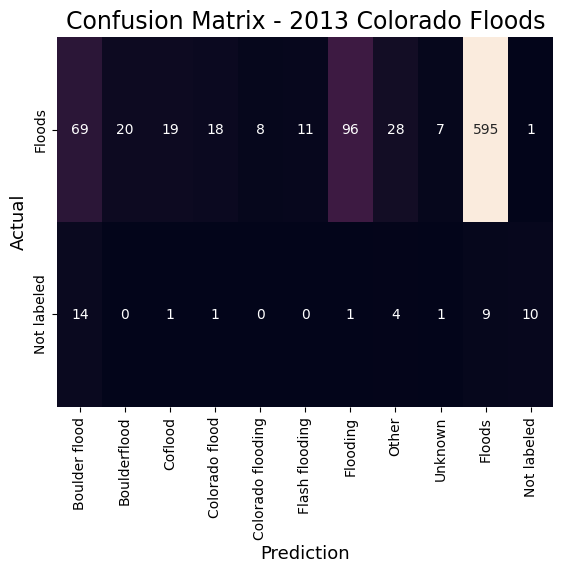

Accuracy: 0.6626506024096386
Precision: 0.9816860348184924
Recall: 0.6626506024096386
F1-score: 0.7872995193006946
Unique Predict Labels:  ['Boulder flood', 'Boulderflood', 'Coflood', 'Colorado flood', 'Colorado flooding', 'Flash flooding', 'Flooding', 'Floods', 'Not labeled', 'Other', 'Unknown']
Unique Actual Labels:  ['Floods', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Floods               604
Flooding              97
Boulder flood         83
Other                 32
Boulderflood          20
Coflood               20
Colorado flood        19
Not labeled           11
Flash flooding        11
Unknown                8
Colorado flooding      8
Name: count, dtype: int64
Confusion Matrix for 2013_Lac_Megantic_train_crash


<Figure size 640x480 with 0 Axes>

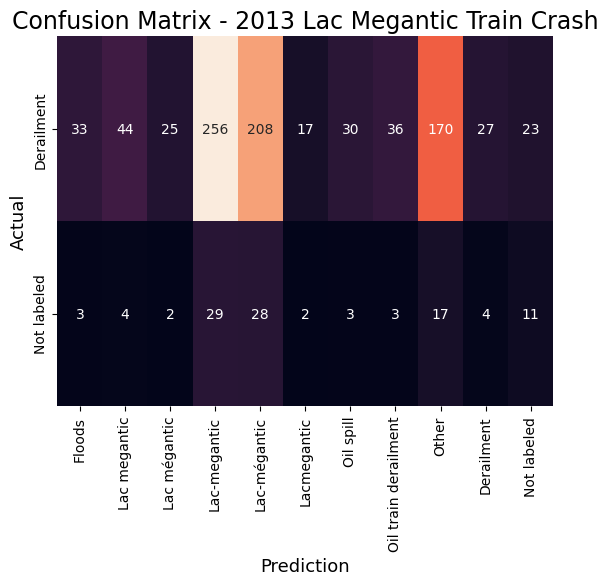

Accuracy: 0.038974358974358976
Precision: 0.8114513696297377
Recall: 0.038974358974358976
F1-score: 0.07056117216117216
Unique Predict Labels:  ['Derailment', 'Floods', 'Lac megantic', 'Lac mégantic', 'Lac-megantic', 'Lac-mégantic', 'Lacmegantic', 'Not labeled', 'Oil spill', 'Oil train derailment', 'Other']
Unique Actual Labels:  ['Derailment', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Lac-megantic            285
Lac-mégantic            236
Other                   187
Lac megantic             48
Oil train derailment     39
Floods                   36
Not labeled              34
Oil spill                33
Derailment               31
Lac mégantic             27
Lacmegantic              19
Name: count, dtype: int64
Confusion Matrix for 2013_Glasgow_helicopter_crash


<Figure size 640x480 with 0 Axes>

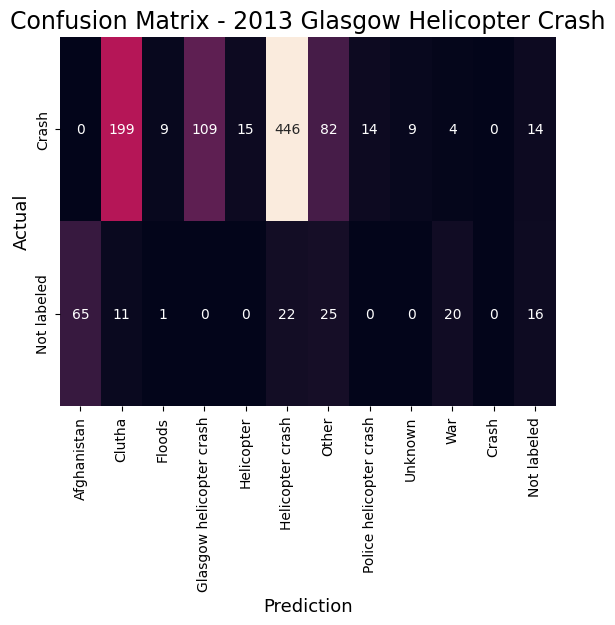

Accuracy: 0.015080113100848256
Precision: 0.0804272698711907
Recall: 0.015080113100848256
F1-score: 0.02539808522248128
Unique Predict Labels:  ['Afghanistan', 'Clutha', 'Floods', 'Glasgow helicopter crash', 'Helicopter', 'Helicopter crash', 'Not labeled', 'Other', 'Police helicopter crash', 'Unknown', 'War']
Unique Actual Labels:  ['Crash', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Helicopter crash            468
Clutha                      210
Glasgow helicopter crash    109
Other                       107
Afghanistan                  65
Not labeled                  30
War                          24
Helicopter                   15
Police helicopter crash      14
Floods                       10
Unknown                       9
Name: count, dtype: int64
Confusion Matrix for 2012_Italy_earthquakes


<Figure size 640x480 with 0 Axes>

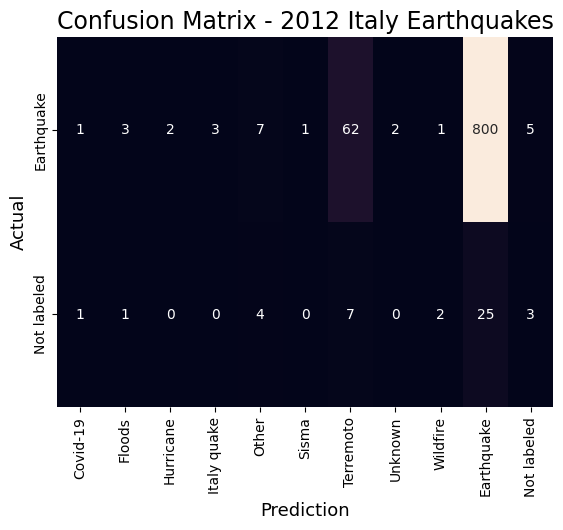

Accuracy: 0.8634408602150537
Precision: 0.9422002280873248
Recall: 0.8634408602150537
F1-score: 0.8968072969314346
Unique Predict Labels:  ['Covid-19', 'Earthquake', 'Floods', 'Hurricane', 'Italy quake', 'Not labeled', 'Other', 'Sisma', 'Terremoto', 'Unknown', 'Wildfire']
Unique Actual Labels:  ['Earthquake', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Earthquake     825
Terremoto       69
Other           11
Not labeled      8
Floods           4
Wildfire         3
Italy quake      3
Unknown          2
Covid-19         2
Hurricane        2
Sisma            1
Name: count, dtype: int64
Confusion Matrix for 2013_Savar_building_collapse


<Figure size 640x480 with 0 Axes>

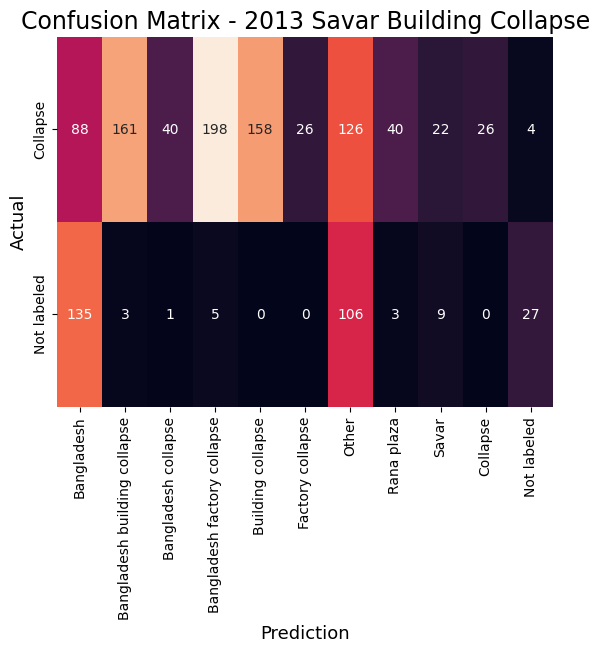

Accuracy: 0.04499151103565365
Precision: 0.9683443781149023
Recall: 0.04499151103565365
F1-score: 0.08428790693682912
Unique Predict Labels:  ['Bangladesh', 'Bangladesh building collapse', 'Bangladesh collapse', 'Bangladesh factory collapse', 'Building collapse', 'Collapse', 'Factory collapse', 'Not labeled', 'Other', 'Rana plaza', 'Savar']
Unique Actual Labels:  ['Collapse', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Other                           232
Bangladesh                      223
Bangladesh factory collapse     203
Bangladesh building collapse    164
Building collapse               158
Rana plaza                       43
Bangladesh collapse              41
Savar                            31
Not labeled                      31
Collapse                         26
Factory collapse                 26
Name: count, dtype: int64
Confusion Matrix for 2013_NY_train_crash


<Figure size 640x480 with 0 Axes>

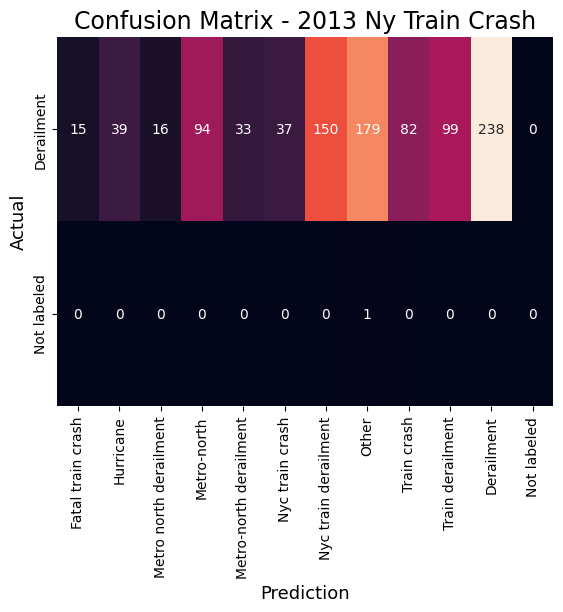

Accuracy: 0.24211597151576805
Precision: 0.9989827060020345
Recall: 0.24211597151576805
F1-score: 0.38976702299751514
Unique Predict Labels:  ['Derailment', 'Fatal train crash', 'Hurricane', 'Metro north derailment', 'Metro-north', 'Metro-north derailment', 'Nyc train crash', 'Nyc train derailment', 'Other', 'Train crash', 'Train derailment']
Unique Actual Labels:  ['Derailment', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Derailment                238
Other                     180
Nyc train derailment      150
Train derailment           99
Metro-north                94
Train crash                82
Hurricane                  39
Nyc train crash            37
Metro-north derailment     33
Metro north derailment     16
Fatal train crash          15
Name: count, dtype: int64
Confusion Matrix for 2013_Manila_floods


<Figure size 640x480 with 0 Axes>

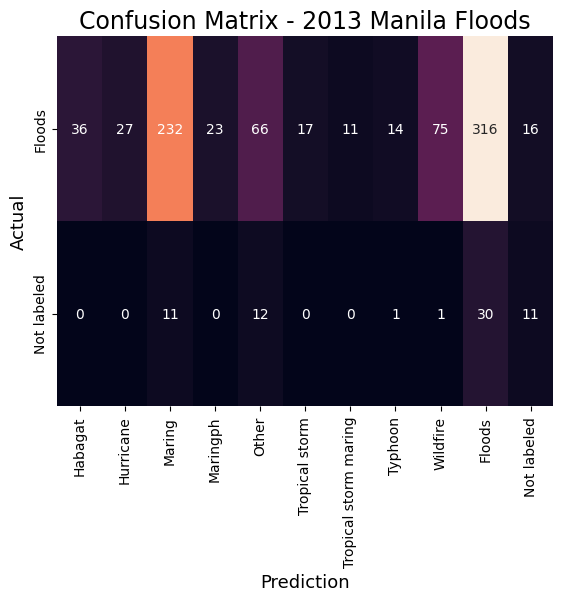

Accuracy: 0.36373748609566187
Precision: 0.8761551227618213
Recall: 0.36373748609566187
F1-score: 0.5140605883865174
Unique Predict Labels:  ['Floods', 'Habagat', 'Hurricane', 'Maring', 'Maringph', 'Not labeled', 'Other', 'Tropical storm', 'Tropical storm maring', 'Typhoon', 'Wildfire']
Unique Actual Labels:  ['Floods', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Floods                   346
Maring                   243
Other                     78
Wildfire                  76
Habagat                   36
Not labeled               27
Hurricane                 27
Maringph                  23
Tropical storm            17
Typhoon                   15
Tropical storm maring     11
Name: count, dtype: int64
Confusion Matrix for 2012_Guatemala_earthquake


<Figure size 640x480 with 0 Axes>

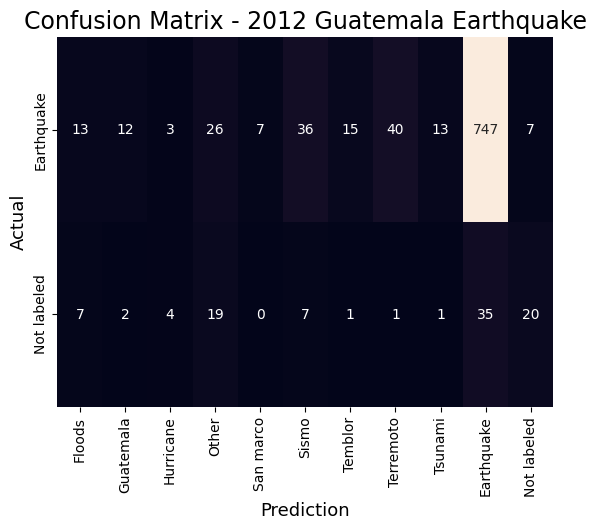

Accuracy: 0.7549212598425197
Precision: 0.9347639156465202
Recall: 0.7549212598425197
F1-score: 0.8252503383313644
Unique Predict Labels:  ['Earthquake', 'Floods', 'Guatemala', 'Hurricane', 'Not labeled', 'Other', 'San marco', 'Sismo', 'Temblor', 'Terremoto', 'Tsunami']
Unique Actual Labels:  ['Earthquake', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Earthquake     782
Other           45
Sismo           43
Terremoto       41
Not labeled     27
Floods          20
Temblor         16
Tsunami         14
Guatemala       14
Hurricane        7
San marco        7
Name: count, dtype: int64
Confusion Matrix for 2013_Russia_meteor


<Figure size 640x480 with 0 Axes>

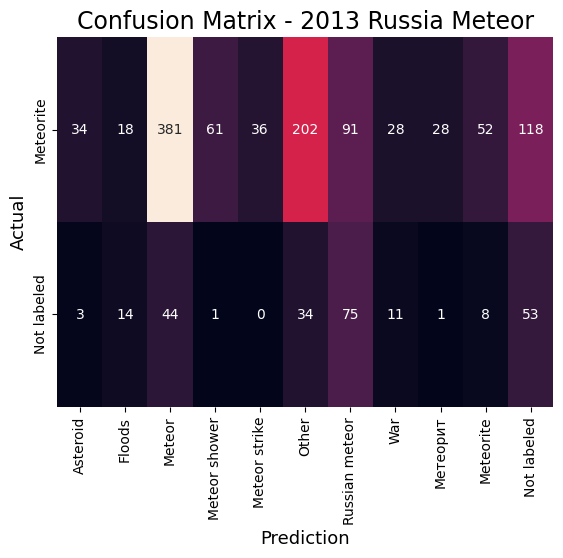

Accuracy: 0.08120649651972157
Precision: 0.7616079383816592
Recall: 0.08120649651972157
F1-score: 0.12428167119405382
Unique Predict Labels:  ['Asteroid', 'Floods', 'Meteor', 'Meteor shower', 'Meteor strike', 'Meteorite', 'Not labeled', 'Other', 'Russian meteor', 'War', 'Метеорит']
Unique Actual Labels:  ['Meteorite', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Meteor            425
Other             236
Not labeled       171
Russian meteor    166
Meteor shower      62
Meteorite          60
War                39
Asteroid           37
Meteor strike      36
Floods             32
Метеорит           29
Name: count, dtype: int64
Confusion Matrix for 2012_Venezuela_refinery


<Figure size 640x480 with 0 Axes>

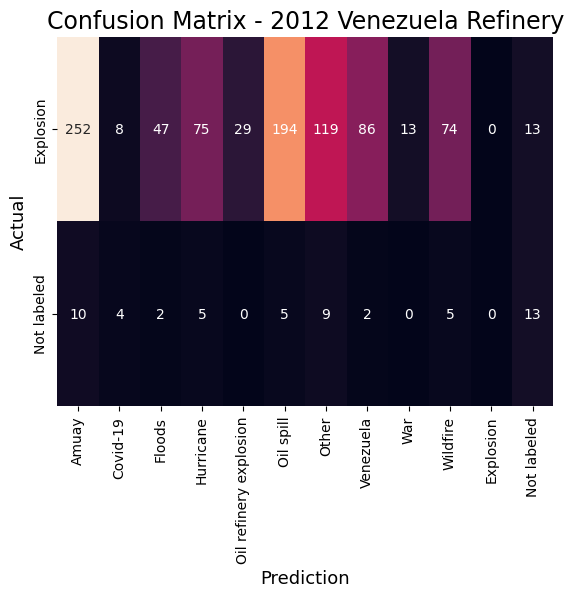

Accuracy: 0.013471502590673576
Precision: 0.02849740932642487
Recall: 0.013471502590673576
F1-score: 0.01829463314782831
Unique Predict Labels:  ['Amuay', 'Covid-19', 'Floods', 'Hurricane', 'Not labeled', 'Oil refinery explosion', 'Oil spill', 'Other', 'Venezuela', 'War', 'Wildfire']
Unique Actual Labels:  ['Explosion', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Amuay                     262
Oil spill                 199
Other                     128
Venezuela                  88
Hurricane                  80
Wildfire                   79
Floods                     49
Oil refinery explosion     29
Not labeled                26
War                        13
Covid-19                   12
Name: count, dtype: int64
Confusion Matrix for 2012_Philipinnes_floods


<Figure size 640x480 with 0 Axes>

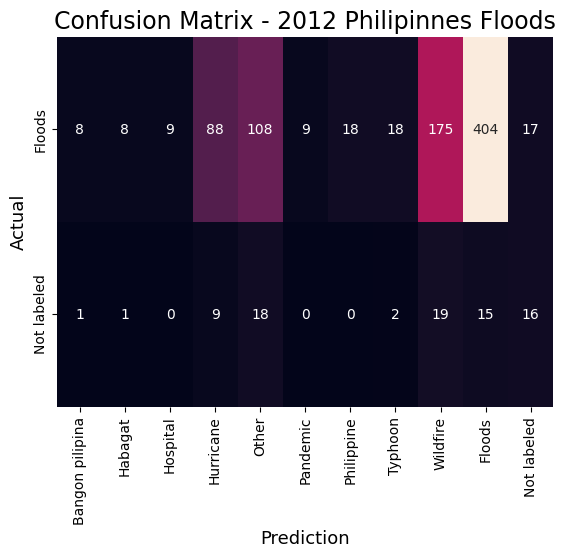

Accuracy: 0.44538706256627786
Precision: 0.9230260219815212
Recall: 0.44538706256627786
F1-score: 0.6006888298401898
Unique Predict Labels:  ['Bangon pilipina', 'Floods', 'Habagat', 'Hospital', 'Hurricane', 'Not labeled', 'Other', 'Pandemic', 'Philippine', 'Typhoon', 'Wildfire']
Unique Actual Labels:  ['Floods', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Floods             419
Wildfire           194
Other              126
Hurricane           97
Not labeled         33
Typhoon             20
Philippine          18
Hospital             9
Pandemic             9
Habagat              9
Bangon pilipina      9
Name: count, dtype: int64
Confusion Matrix for 2013_Boston_bombings


<Figure size 640x480 with 0 Axes>

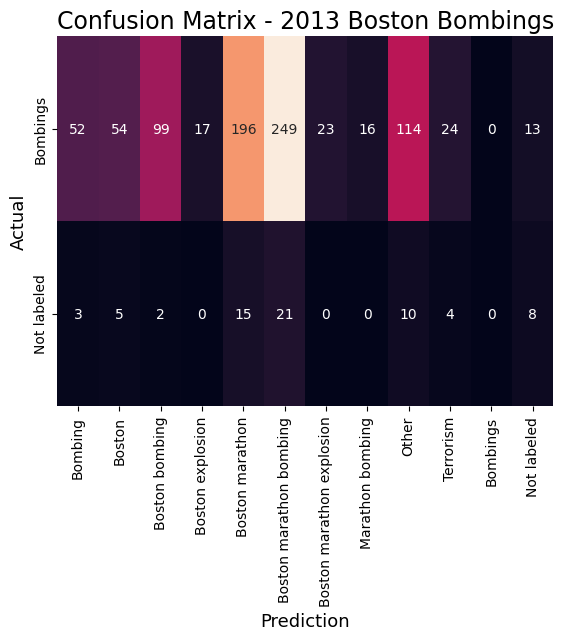

Accuracy: 0.008648648648648649
Precision: 0.028005148005148004
Recall: 0.008648648648648649
F1-score: 0.013215912541755236
Unique Predict Labels:  ['Bombing', 'Boston', 'Boston bombing', 'Boston explosion', 'Boston marathon', 'Boston marathon bombing', 'Boston marathon explosion', 'Marathon bombing', 'Not labeled', 'Other', 'Terrorism']
Unique Actual Labels:  ['Bombings', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Boston marathon bombing      270
Boston marathon              211
Other                        124
Boston bombing               101
Boston                        59
Bombing                       55
Terrorism                     28
Boston marathon explosion     23
Not labeled                   21
Boston explosion              17
Marathon bombing              16
Name: count, dtype: int64
Confusion Matrix for 2012_Colorado_wildfires


<Figure size 640x480 with 0 Axes>

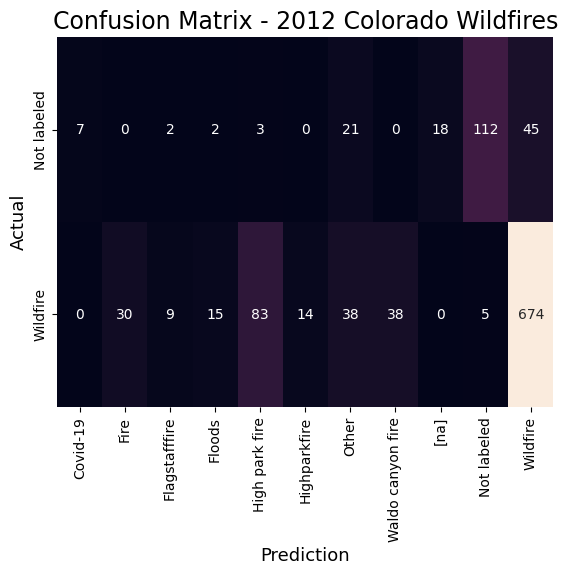

Accuracy: 0.7043010752688172
Precision: 0.941148643198982
Recall: 0.7043010752688172
F1-score: 0.8023432411855023
Unique Predict Labels:  ['Covid-19', 'Fire', 'Flagstafffire', 'Floods', 'High park fire', 'Highparkfire', 'Not labeled', 'Other', 'Waldo canyon fire', 'Wildfire', '[na]']
Unique Actual Labels:  ['Not labeled', 'Wildfire']
Number of rows:  25987
parsed_pred_crisistype
Wildfire             719
Not labeled          117
High park fire        86
Other                 59
Waldo canyon fire     38
Fire                  30
[na]                  18
Floods                17
Highparkfire          14
Flagstafffire         11
Covid-19               7
Name: count, dtype: int64
Confusion Matrix for 2013_Spain_train_crash


<Figure size 640x480 with 0 Axes>

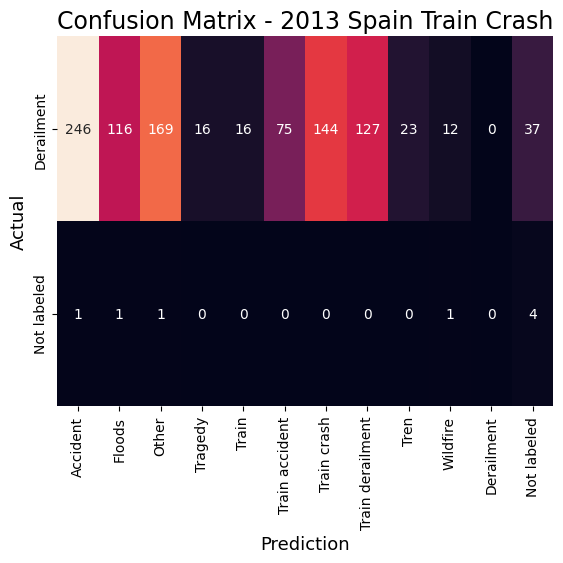

Accuracy: 0.004044489383215369
Precision: 0.0007891686601395842
Recall: 0.004044489383215369
F1-score: 0.0013206495945193044
Unique Predict Labels:  ['Accident', 'Floods', 'Not labeled', 'Other', 'Tragedy', 'Train', 'Train accident', 'Train crash', 'Train derailment', 'Tren', 'Wildfire']
Unique Actual Labels:  ['Derailment', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Accident            247
Other               170
Train crash         144
Train derailment    127
Floods              117
Train accident       75
Not labeled          41
Tren                 23
Train                16
Tragedy              16
Wildfire             13
Name: count, dtype: int64
Confusion Matrix for 2013_West_Texas_explosion


<Figure size 640x480 with 0 Axes>

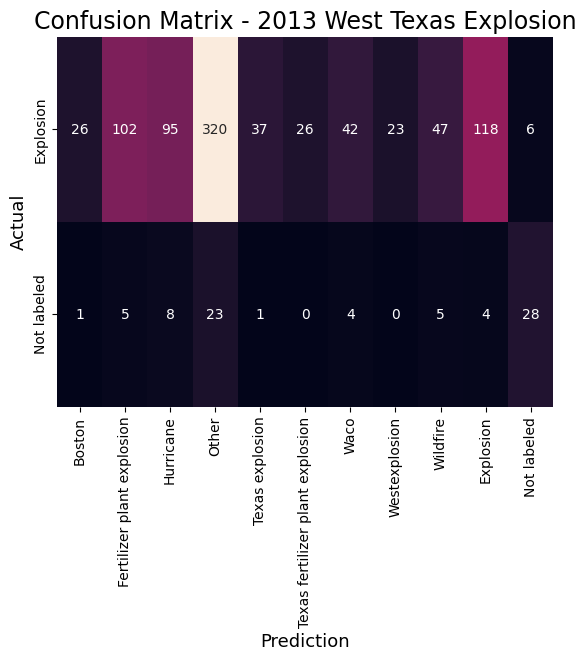

Accuracy: 0.15852334419109662
Precision: 0.9548884540199377
Recall: 0.15852334419109662
F1-score: 0.2663227172213503
Unique Predict Labels:  ['Boston', 'Explosion', 'Fertilizer plant explosion', 'Hurricane', 'Not labeled', 'Other', 'Texas explosion', 'Texas fertilizer plant explosion', 'Waco', 'Westexplosion', 'Wildfire']
Unique Actual Labels:  ['Explosion', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Other                               343
Explosion                           122
Fertilizer plant explosion          107
Hurricane                           103
Wildfire                             52
Waco                                 46
Texas explosion                      38
Not labeled                          34
Boston                               27
Texas fertilizer plant explosion     26
Westexplosion                        23
Name: count, dtype: int64
Confusion Matrix for 2013_Alberta_floods


<Figure size 640x480 with 0 Axes>

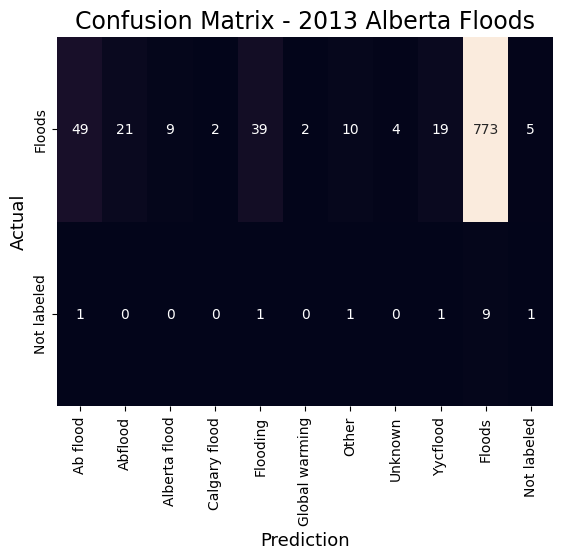

Accuracy: 0.8173178458289335
Precision: 0.9763415857137585
Recall: 0.8173178458289335
F1-score: 0.8896093540750136
Unique Predict Labels:  ['Ab flood', 'Abflood', 'Alberta flood', 'Calgary flood', 'Flooding', 'Floods', 'Global warming', 'Not labeled', 'Other', 'Unknown', 'Yycflood']
Unique Actual Labels:  ['Floods', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Floods            782
Ab flood           50
Flooding           40
Abflood            21
Yycflood           20
Other              11
Alberta flood       9
Not labeled         6
Unknown             4
Global warming      2
Calgary flood       2
Name: count, dtype: int64
Confusion Matrix for 2013_Typhoon_Yolanda


<Figure size 640x480 with 0 Axes>

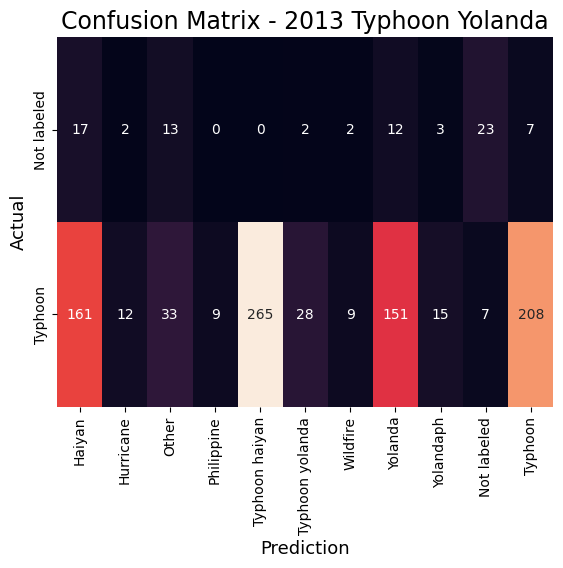

Accuracy: 0.23595505617977527
Precision: 0.950830225431741
Recall: 0.23595505617977527
F1-score: 0.3771278636659175
Unique Predict Labels:  ['Haiyan', 'Hurricane', 'Not labeled', 'Other', 'Philippine', 'Typhoon', 'Typhoon haiyan', 'Typhoon yolanda', 'Wildfire', 'Yolanda', 'Yolandaph']
Unique Actual Labels:  ['Not labeled', 'Typhoon']
Number of rows:  25987
parsed_pred_crisistype
Typhoon haiyan     265
Typhoon            215
Haiyan             178
Yolanda            163
Other               46
Not labeled         30
Typhoon yolanda     30
Yolandaph           18
Hurricane           14
Wildfire            11
Philippine           9
Name: count, dtype: int64
Confusion Matrix for 2013_LA_airport_shootings


<Figure size 640x480 with 0 Axes>

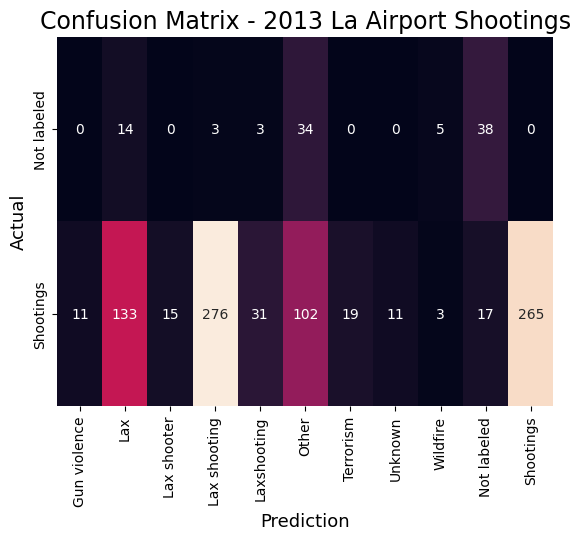

Accuracy: 0.30918367346938774
Precision: 0.9694063079777365
Recall: 0.30918367346938774
F1-score: 0.4654661167602929
Unique Predict Labels:  ['Gun violence', 'Lax', 'Lax shooter', 'Lax shooting', 'Laxshooting', 'Not labeled', 'Other', 'Shootings', 'Terrorism', 'Unknown', 'Wildfire']
Unique Actual Labels:  ['Not labeled', 'Shootings']
Number of rows:  25987
parsed_pred_crisistype
Lax shooting    279
Shootings       265
Lax             147
Other           136
Not labeled      55
Laxshooting      34
Terrorism        19
Lax shooter      15
Unknown          11
Gun violence     11
Wildfire          8
Name: count, dtype: int64
Confusion Matrix for 2013_Bohol_earthquake


<Figure size 640x480 with 0 Axes>

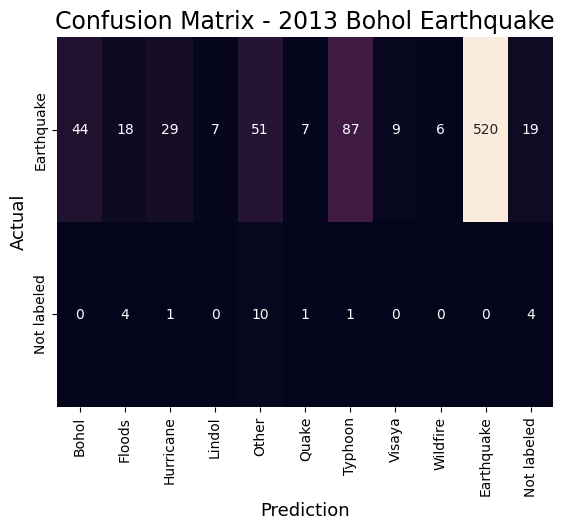

Accuracy: 0.6405867970660146
Precision: 0.9787923886467524
Recall: 0.6405867970660146
F1-score: 0.7740684127393197
Unique Predict Labels:  ['Bohol', 'Earthquake', 'Floods', 'Hurricane', 'Lindol', 'Not labeled', 'Other', 'Quake', 'Typhoon', 'Visaya', 'Wildfire']
Unique Actual Labels:  ['Earthquake', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Earthquake     520
Typhoon         88
Other           61
Bohol           44
Hurricane       30
Not labeled     23
Floods          22
Visaya           9
Quake            8
Lindol           7
Wildfire         6
Name: count, dtype: int64
Confusion Matrix for 2013_Queensland_floods


<Figure size 640x480 with 0 Axes>

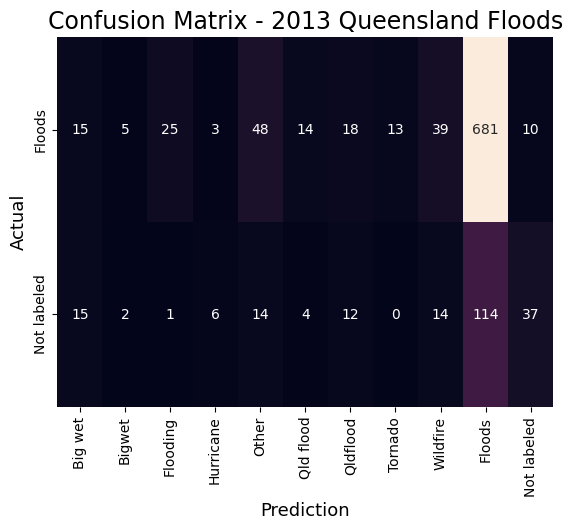

Accuracy: 0.6587155963302752
Precision: 0.8426661854234878
Recall: 0.6587155963302752
F1-score: 0.7091659068262746
Unique Predict Labels:  ['Big wet', 'Bigwet', 'Flooding', 'Floods', 'Hurricane', 'Not labeled', 'Other', 'Qld flood', 'Qldflood', 'Tornado', 'Wildfire']
Unique Actual Labels:  ['Floods', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Floods         795
Other           62
Wildfire        53
Not labeled     47
Big wet         30
Qldflood        30
Flooding        26
Qld flood       18
Tornado         13
Hurricane        9
Bigwet           7
Name: count, dtype: int64
Confusion Matrix for 2013_Singapore_haze


<Figure size 640x480 with 0 Axes>

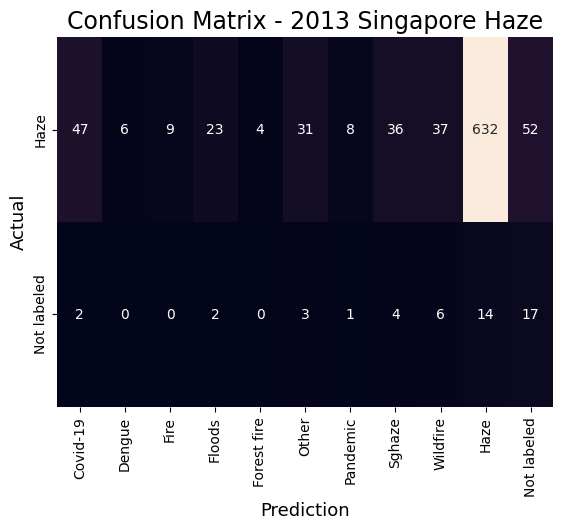

Accuracy: 0.6948608137044968
Precision: 0.9399281554653625
Recall: 0.6948608137044968
F1-score: 0.7974072201398064
Unique Predict Labels:  ['Covid-19', 'Dengue', 'Fire', 'Floods', 'Forest fire', 'Haze', 'Not labeled', 'Other', 'Pandemic', 'Sghaze', 'Wildfire']
Unique Actual Labels:  ['Haze', 'Not labeled']
Number of rows:  25987
parsed_pred_crisistype
Haze           646
Not labeled     69
Covid-19        49
Wildfire        43
Sghaze          40
Other           34
Floods          25
Fire             9
Pandemic         9
Dengue           6
Forest fire      4
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

In [307]:
# Get the unique values in the 'Label' column
unique_event_labels = testing_df2['Label'].unique()
# Remove 'Label' from the unique_labels
unique_event_labels = unique_event_labels[unique_event_labels != 'Label']

# Loop over the unique labels and run the confusion matrix for each label
for x in unique_event_labels:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(f'Confusion Matrix for {x}')
        df = testing_df2[testing_df2['Label'] == x]
        top_labels(df, 'parsed_pred_crisistype', top_x_threshold=10)
        plt_confusion_matrix_CrisisEventbyType(df['type'], df['parsed_pred_crisistype']);


### <a id='toc1_5_2_'></a>[Information Type Results](#toc0_)

In [37]:
#######################################################
#    INFORMATION TYPE PARSER                          #
#######################################################
testing_df2 = pd.read_csv(r"C:\Users\wingy\UTS\Crisistunity - Experiments - Results\Information Type\combined_information_type.csv")
#Apply Parse function for information type and get answers in sentence case
testing_df2['parsed_pred_infotype'] = testing_df2['Pred_InformationType_v9v3'].apply(parse_label_infotype)
singular_label(testing_df2,'parsed_pred_infotype')
rename_label(testing_df2,'parsed_pred_infotype', 'InformationType')
top_labels(testing_df2, 'parsed_pred_infotype',top_x_threshold=8)
infotype_df=testing_df2[["TweetText","InformationType","Pred_InformationType_v9v3","parsed_pred_infotype"]]

#Count the values in the "Label" column
label_counts = testing_df2['parsed_pred_infotype'].value_counts()
label_counts
# save df as csv testing_df2
# testing_df2.to_csv(r"C:\Users\wingy\OneDrive\DATA SCIENCE\ilab2\Parsed Resuts\infotype2.csv", index = None, header=True)

parsed_pred_infotype
Affected individuals            8520
Other Useful Information        5341
Not labeled                     4895
Sympathy and support            2706
Caution and advice              1969
Donations and volunteering      1307
Infrastructure and utilities    1128
Other                            111
Unknown                           10
Name: count, dtype: int64

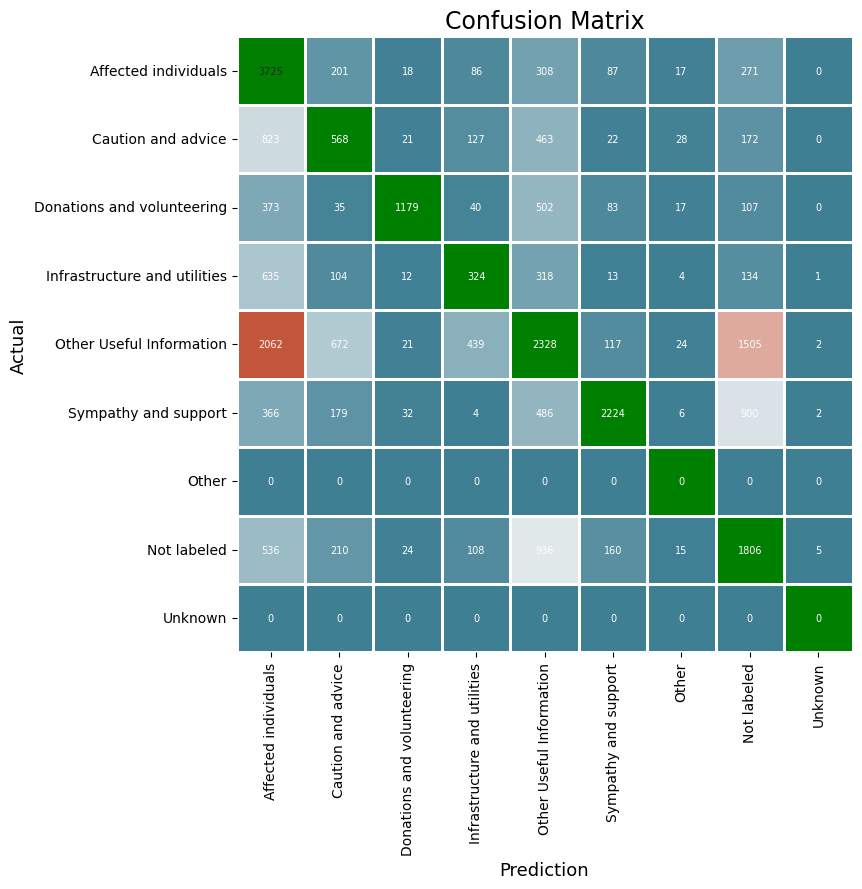

Accuracy: 0.46769538615461576
Precision: 0.5091543632219417
Recall: 0.46769538615461576
F1-score: 0.46539551243909744
Unique Predict Labels:  ['Affected individuals', 'Caution and advice', 'Donations and volunteering', 'Infrastructure and utilities', 'Not labeled', 'Other', 'Other Useful Information', 'Sympathy and support', 'Unknown']
Unique Actual Labels:  ['Affected individuals', 'Caution and advice', 'Donations and volunteering', 'Infrastructure and utilities', 'Not labeled', 'Other Useful Information', 'Sympathy and support']
Number of rows:  25987
parsed_pred_infotype
Affected individuals            8520
Other Useful Information        5341
Not labeled                     4895
Sympathy and support            2706
Caution and advice              1969
Donations and volunteering      1307
Infrastructure and utilities    1128
Other                            111
Unknown                           10
Name: count, dtype: int64


c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

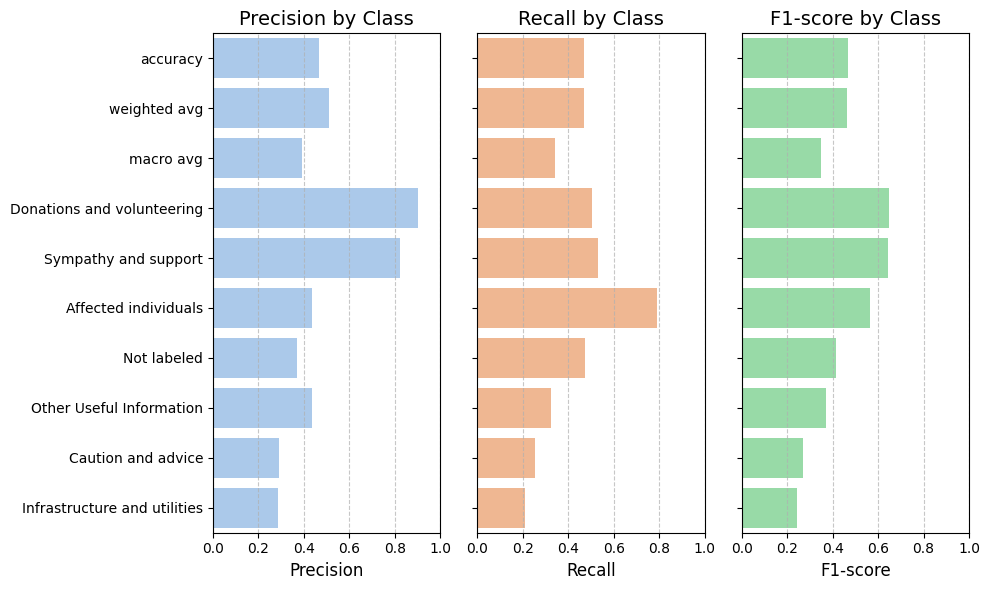

                              precision    recall  f1-score       support
accuracy                       0.467695  0.467695  0.467695      0.467695
weighted avg                   0.509154  0.467695  0.465396  25987.000000
macro avg                      0.393520  0.343309  0.350594  25987.000000
Donations and volunteering     0.902066  0.504709  0.647269   2336.000000
Sympathy and support           0.821877  0.529650  0.644171   4199.000000
Affected individuals           0.437207  0.790367  0.562986   4713.000000
Not labeled                    0.368948  0.475263  0.415411   3800.000000
Other Useful Information       0.435873  0.324686  0.372153   7170.000000
Caution and advice             0.288471  0.255396  0.270928   2224.000000
Infrastructure and utilities   0.287234  0.209709  0.242424   1545.000000


In [38]:
# CM for Information Type 
#remove NULL entries from the dataframe
testing_df2 = testing_df2[testing_df2['InformationType'].notnull()]
#Merge not labeled and not applicable from the dataframe
testing_df2['InformationType'] = testing_df2['InformationType'].replace(to_replace={'Not applicable': 'Not labeled'})

plt_confusion_matrix(testing_df2['InformationType'],testing_df2['parsed_pred_infotype'])

### Informativeness Results

In [ ]:
# #######################################################
# #    INFORMATIVENESS PARSER                           #
# #######################################################
# testing_df2 = pd.read_csv(r"C:\Users\wingy\OneDrive\DATA SCIENCE\ilab2\Informativenenss\infoness_combined.csv")

# testing_df2['parsed_Informativeness_pred'] = testing_df2['Informativeness_pred'].apply(parse_label_infoness)
# # Replace underscores
# testing_df2['Informativeness'] = testing_df2['Informativeness'].str.replace('- ', '')
# # testing_df2['parsed_Informativeness_pred'] = testing_df2['parsed_Informativeness_pred'].str.replace('.', '')
# label_counts = testing_df2['parsed_Informativeness_pred'].value_counts()
# label_counts.head(100)


parsed_Informativeness_pred
Related and informative                                                                                                             12988
Related but not informative                                                                                                          7021
Not related                                                                                                                            75
Unknown                                                                                                                                 4
Related  but not informative                                                                                                            1
Apparently the bombing in Boston was by Chechen people (some sort of Russian) so glad my peeps escaped that one haha                    1
Tragic                                                                                                                                  1
RT @ba

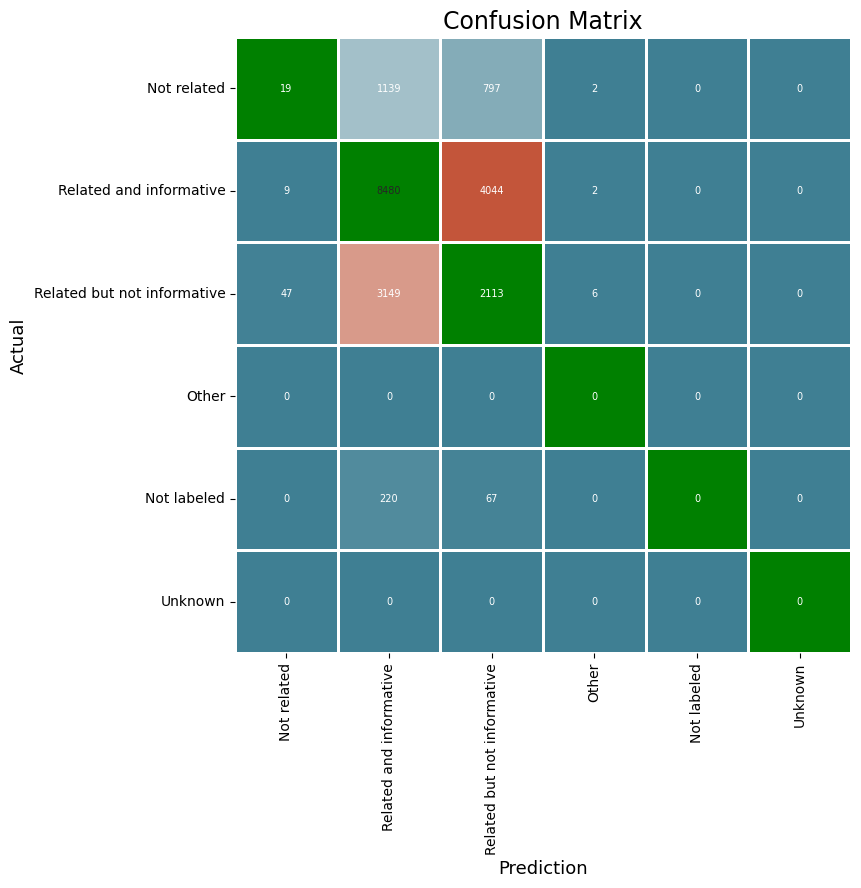

Accuracy: 0.5281178461232209
Precision: 0.5115744466021049
Recall: 0.5281178461232209
F1-score: 0.5069609023987787
Unique Predict Labels:  ['Not related', 'Other', 'Related and informative', 'Related but not informative']
Unique Actual Labels:  ['Not labeled', 'Not related', 'Related and informative', 'Related but not informative']
Number of rows:  20094
parsed_Informativeness_pred
Related and informative        12988
Related but not informative     7021
Not related                       75
Other                             10
Name: count, dtype: int64


c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\

<Figure size 640x480 with 0 Axes>

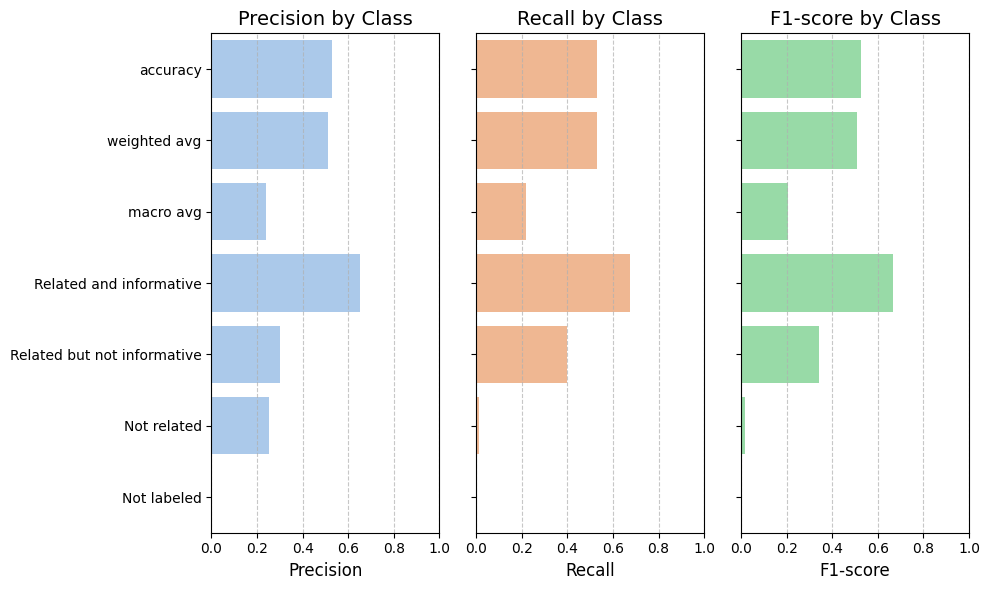

                             precision    recall  f1-score       support
accuracy                      0.528118  0.528118  0.528118      0.528118
weighted avg                  0.511574  0.528118  0.506961  20094.000000
macro avg                     0.241440  0.216754  0.205155  20094.000000
Related and informative       0.652910  0.676506  0.664499  12535.000000
Related but not informative   0.300954  0.397554  0.342575   5315.000000
Not related                   0.253333  0.009709  0.018701   1957.000000
Not labeled                   0.000000  0.000000  0.000000    287.000000


In [30]:
# CM for Informativeness  
df2 = testing_df2
# #Merge not labeled and not applicable from the dataframe
testing_df2['Informativeness'] = testing_df2['Informativeness'].replace(to_replace={'Not applicable': 'Not labeled'})
top_labels(df2, 'parsed_Informativeness_pred', top_x_threshold=4)
plt_confusion_matrix(testing_df2['Informativeness'],testing_df2['parsed_Informativeness_pred'])

### <a id='toc1_5_3_'></a>[Country Results](#toc0_)

In [ ]:
#######################################################
#    COUNTRY PARSER                                   #
#######################################################
testing_df2 = pd.read_csv(r"C:\Users\wingy\UTS\Crisistunity - Experiments - Results\Country\result_df_country_e2.csv")
# Apply Parse function
testing_df2['parsed_pred_country'] = testing_df2['country_pred'].apply(parse_label_country)
rename_label(df=testing_df2,parsed_column='parsed_pred_country', label_column='country')
top_labels(df=testing_df2, parsed_column='parsed_pred_country', top_x_threshold=19)

# Count the values in the "Label" column
label_counts = testing_df2['parsed_pred_country'].value_counts()
print(label_counts)
country_df=testing_df2[["TweetText","country","InformationType","country_pred","parsed_pred_country"]]


parsed_pred_country
Unknown                              8326
Philippines                          3483
United States                        2136
Canada                               1726
Italy                                1547
Australia                            1363
Bangladesh                           1056
Brazil                                877
Singapore                             806
Spain                                 790
Guatemala                             761
Costa Rica                            727
Venezuela, Bolivarian Republic of     629
Russian Federation                    597
Other                                 544
United Kingdom                        230
Mexico                                156
Colombia                               83
Chile                                  80
Ecuador                                77
Name: count, dtype: int64


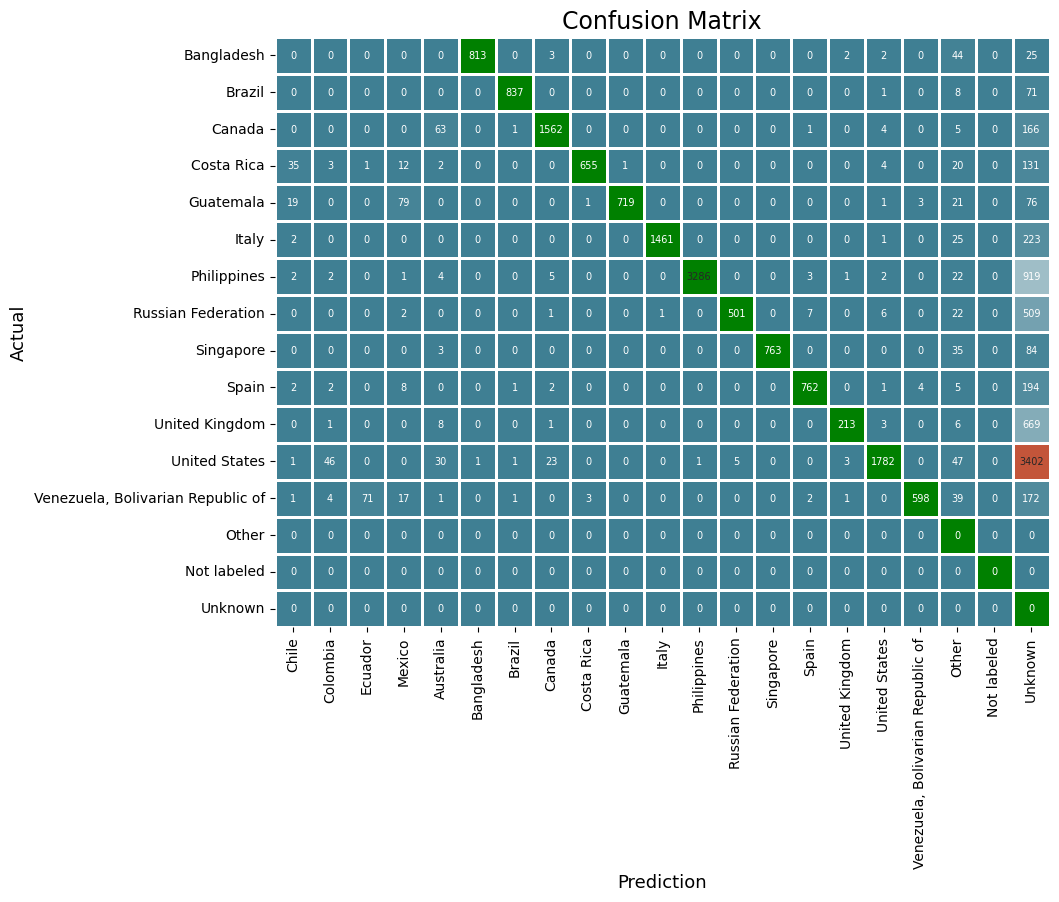

Accuracy: 0.6492559844727195
Precision: 0.9845621359268543
Recall: 0.6492559844727195
F1-score: 0.7584358069428289
Unique Predict Labels:  ['Australia', 'Bangladesh', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Ecuador', 'Guatemala', 'Italy', 'Mexico', 'Other', 'Philippines', 'Russian Federation', 'Singapore', 'Spain', 'United Kingdom', 'United States', 'Unknown', 'Venezuela, Bolivarian Republic of']
Unique Actual Labels:  ['Australia', 'Bangladesh', 'Brazil', 'Canada', 'Costa Rica', 'Guatemala', 'Italy', 'Philippines', 'Russian Federation', 'Singapore', 'Spain', 'United Kingdom', 'United States', 'Venezuela, Bolivarian Republic of']
Number of rows:  23185
parsed_pred_country
Unknown                              7298
Philippines                          3287
United States                        1807
Canada                               1597
Italy                                1462
Australia                            1212
Brazil                                842
Banglades

c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

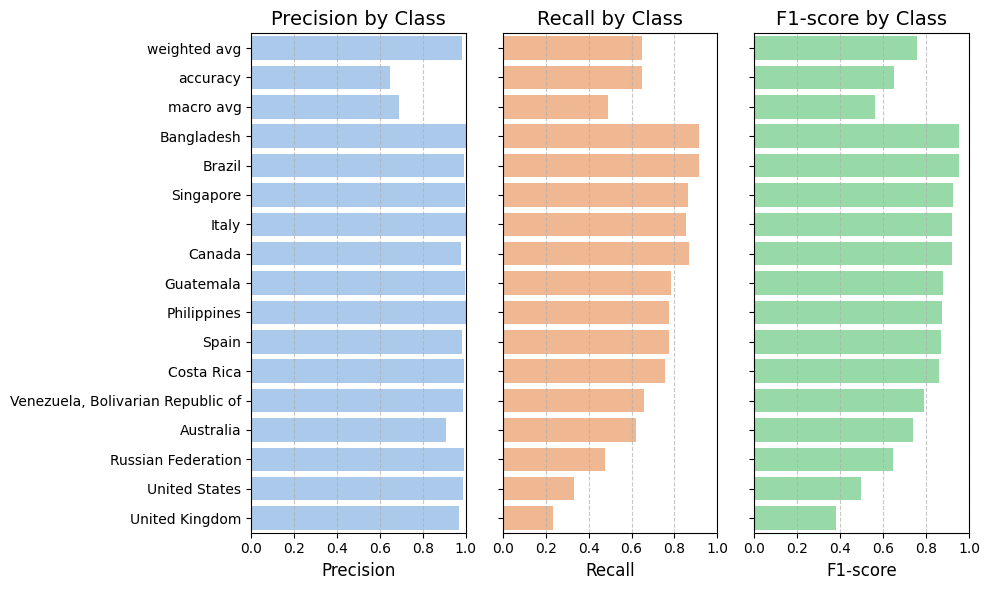

                                   precision    recall  f1-score       support
weighted avg                        0.984562  0.649256  0.758436  23185.000000
accuracy                            0.649256  0.649256  0.649256      0.649256
macro avg                           0.689285  0.491420  0.560040  23185.000000
Bangladesh                          0.998771  0.914511  0.954786    889.000000
Brazil                              0.994062  0.912759  0.951677    917.000000
Singapore                           0.998691  0.862147  0.925409    885.000000
Italy                               0.999316  0.853388  0.920605   1712.000000
Canada                              0.978084  0.866815  0.919094   1802.000000
Guatemala                           0.998611  0.782372  0.877364    919.000000
Philippines                         0.999696  0.773723  0.872312   4247.000000
Spain                               0.983226  0.776758  0.867882    981.000000
Costa Rica                          0.993930  0.7581

In [34]:
# CM for Country 

#remove NULL entries from the dataframe
testing_df2 = testing_df2[testing_df2['country'].notnull()]
#remove Not labeled entries from the dataframe
testing_df2 = testing_df2[testing_df2['country'] != 'Not labeled']
plt_confusion_matrix(testing_df2['country'],testing_df2['parsed_pred_country'])

# class_label_drop=['Unknown', 'Not labeled', 'Other', 'Mexico','Chile','Colombia','Ecuador']
# class_metrics(testing_df2['country'],testing_df2['parsed_pred_country'],class_label_drop=class_label_drop)
